# Multiprocessing in Python

Introduction to using multiple processes in Python with help of multiprocessing library.

## Theorethical introduction

### Processes and threads

- **Process** is an execution context: binary instructions, memory, resources.
- **Thread** in a unit of execution, has virtualized processor. 
- Process has at least one thread, can have many.
- Multiple threads share resources in a context of one process.
- Processes run in a different address spaces.

> **Important note:** There is no multicore multithreading in python!


### Processes and threads in Python
  


| Process                                                                | Thread                                                          |
|------------------------------------------------------------------------|-----------------------------------------------------------------|
|- can run in parallel in Python                                         |- can run only concurrently in Python (GIL) - no multicore       |
|- separate memory space (easy handling, harder communications - IPC)    |- shared memory space (hard management, easy communication)      |
|- larger memory footprint (usually used in tens - hundreds)             |- lightweight (can be used in hundreds - thousands)              |



**Processes are your only option to utilize multiple cores and CPUs in Python**


---------
> **Important note:** In notebooks use if __name__=='__main__': to wrap multiprocessing code, especially Pools.

## Basic usage of multiprocessing library
In this example, we create two processes and try to operate on the same list inside of them.

In [1]:
import multiprocessing as mp

def func(some_list):
  some_list.append("hello")
  print(some_list)

if __name__ == '__main__':
  some_list = ['first']

  p1 = mp.Process(target=func, args=(some_list, ))
  p2 = mp.Process(target=func, args=(some_list, ))

  p1.start()
  p2.start()

  p1.join()
  p2.join()

  print(some_list)

['first', 'hello']
['first', 'hello']
['first']


As you can see, changes made to the list in the subprocesses are not visible in the main process. This is a result of the fact, that memory is copied on creation of the new process. There are few techniques to actually share information between processes.

Let's do something practical before we visit other functinalities of `multiprocessing`.

## Running a task for a list of items

In [2]:
def same_thing(num):
    return num

if __name__ == '__main__':
    items = [1, 2, 3, 4, 5]
    processes = []
    for item in items:
        proc = mp.Process(target=same_thing, args=(item, ))
        proc.start()
        processes.append(proc)
    for proc in processes:
        proc.join()

## Multiprocessing pool - where the fun begins
Allows for easy offloading of tasks to 'worker processes'.

Map functions - keeps order of returned results. If you don't need it, use `imap_unordered` for optimization. You can also run tasks asynchronously with help of apply_async.

In [3]:
from time import sleep
import multiprocessing as mp

def f_sleep(x):
    sleep(2)
    return x*x


def f(x):
    return x*x


if __name__ == '__main__':
  
  with mp.Pool(processes=7) as pool:  # default number of processes: os.cpu_count()
    
    print(pool.map(f, range(10)))

    for i in pool.imap_unordered(f, range(10)):
        print(i)
        
    
    # run tasks asynchronously
    tasks = []   
    
    for i in range(10):
        tasks.append(pool.apply_async(f_sleep, args=(i, )))
    
    # some other code

    # timeout if fetching results takes too long
    for i in tasks:
        print(i.get(timeout=3))

  

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
0
1
4
9
16
25
49
64
81
36
0
1
4
9
16
25
36
49
64
81


## Performance - mandelbrot set
"Embarassingly parallel problem". Let's just skim through it to have a proof.

### Standard implementation

Completed in: 16.23271107673645 seconds


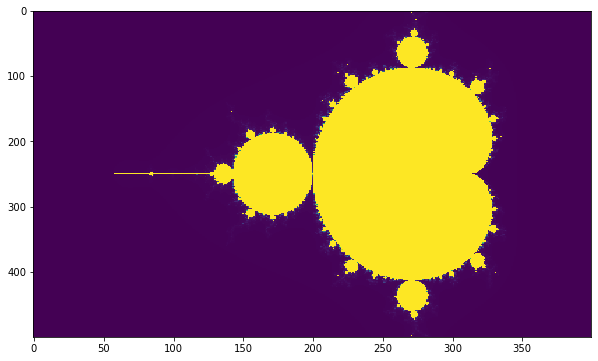

In [4]:
import matplotlib.pyplot as plt
from functools import partial
import time


def mandelbrotCalcRow(yPos, h, w, max_iteration = 1000):
    y0 = yPos * (2/float(h)) - 1 #rescale to -1 to 1
    row = []
    for xPos in range(w):
        x0 = xPos * (3.5/float(w)) - 2.5 #rescale to -2.5 to 1
        iteration, z = 0, 0 + 0j
        c = complex(x0, y0)
        while abs(z) < 2 and iteration < max_iteration:
            z = z**2 + c
            iteration += 1
        row.append(iteration)

    return row


def mandelbrotCalcSet(h, w, max_iteration = 1000):
    partialCalcRow = partial(mandelbrotCalcRow, h=h, w=w, max_iteration = max_iteration)
    mandelImg = list(map(partialCalcRow, range(h)))
    return mandelImg


if __name__ == '__main__':
    start_time = time.time()
    mandelImg = mandelbrotCalcSet(500, 400, 1000)
    print("Completed in: %s seconds" % (time.time() - start_time))
    
    plt.figure(figsize=(10, 6), facecolor='w', edgecolor='k')
plt.imshow(mandelImg,  interpolation='nearest', aspect='auto')

### Parallel implmentation
Let's use a pool of process to caluclate rows in parallel.


Completed in: 4.333096981048584 seconds


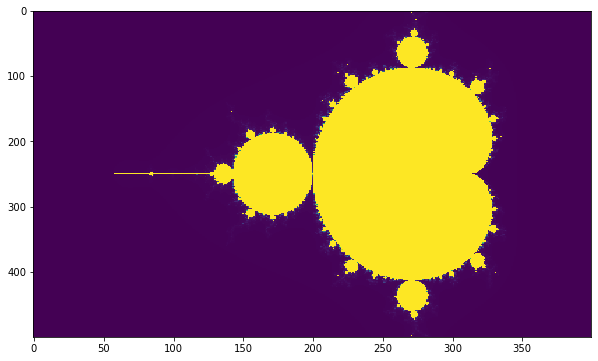

In [5]:
import multiprocessing as mp


def mandelbrotCalcSet(h, w, max_iteration = 1000):

    partialCalcRow = partial(mandelbrotCalcRow, h=h, w=w, max_iteration = max_iteration)
 
    pool = mp.Pool(processes=4)
    mandelImg = pool.map(partialCalcRow, range(h)) 
    pool.close()
    pool.join()
 
    return mandelImg


if __name__ == '__main__':
    start_time = time.time()
    mandelImg = mandelbrotCalcSet(500, 400, 1000)
    print("Completed in: %s seconds" % (time.time() - start_time))
    
    plt.figure(figsize=(10, 6), facecolor='w', edgecolor='k')
    plt.imshow(mandelImg,  interpolation='nearest', aspect='auto')

We were able to achieve a significant speed-up.

## Practical example - reading large csv, splitting, processing
Code like this was used to process 300GB CSV in a real project.
OA: https://github.com/nuada

### Libs

In [6]:
%pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
import glob
import multiprocessing as mp
import os
import os.path

import pandas as pd

import pyarrow as pa
import pyarrow.parquet as pq

os.makedirs('in_dir', exist_ok=True)
os.makedirs('out_dir', exist_ok=True)

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

### Preprocess the file
Split input file into chunks. Chunksize should be more like 1e7.

In [8]:
column_names = [
    'sepal_length', 'sepal_width', 'petal_length',
    'petal_width', 'class_name'
]
reader = pd.read_table('iris.data.gz', chunksize=100,
                       names=column_names, compression='gzip')

for chunk_no, chunk in enumerate(reader):
    pq.write_table(
        pa.Table.from_pandas(chunk),
        os.path.join('in_dir', 'iris-{:04d}.parquet'.format(chunk_no)),
        compression='snappy'
    )

### Process in parallel

In [9]:
def do_work(filename):
    chunk = pq.read_table(filename).to_pandas()
    # Some processesing ...
    pq.write_table(pa.Table.from_pandas(chunk),
                   filename.replace('in', 'out'),
                   compression='snappy')

with mp.Pool() as pool:
    pool.map(do_work, glob.glob('in_dir/*.parquet'))

### Collect results

In [10]:
df = pq.read_table('out_dir').to_pandas()
# Aggregate the results into final report ...
df.to_csv('report.txt')

## Exchanging data between processes

### Pipes
- objects have to be picklable
- pretty slow
- objects > 32MB might cause errors
- pipe is basically a buffer
- data might become corrupted if to processes write to the same end of the pipe at the same time
- implemented in os
- can be uni- or bi- dirctional

In this example we try to send data from the child process to the main process.

In [11]:
def func(conn):
    conn.send("Hi there, bud!")
    conn.close()
    

if __name__ == '__main__':

  one_end, second_end = mp.Pipe()

  for i in range(10):
      p = mp.Process(target=func, args=(second_end,))
      p.start()
      print(one_end.recv())
      p.join()

Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!
Hi there, bud!


### Queue
- higher level than pipes, safer
- can store python objects
- slow


In [12]:
def func(results):
    results.put(["An answer is 42"])
    
if __name__ == '__main__':

  results = mp.Queue()

  p1 = mp.Process(target=func, args=(results, ))
  p1.start()
  p1.join()

  print(results.get())

['An answer is 42']


## Synchronization

To ilustrate synchronization mechanisms, we use shared memory explained later in this notebook.

### Trivial example
Sometimes we want to ensure some resources are not used by multiple processes at the same time. In this example, process are waiting for lock to be released in order not to mix up their output.

Other examples: database, files.

In [13]:
import multiprocessing as mp

def f(lock, i):
    lock.acquire()
    try:
        print('hello world', i)
    finally:
        lock.release()

if __name__ == '__main__':
    lock = mp.Lock()

    for num in range(2):
        mp.Process(target=f, args=(lock, num)).start()

hello world 0
hello world 1


## Sharing state

In general, you should design your software to avoid sharing memory between process. If the use case requires it, multiprocessing provides a way to share memory spaces.

### Shared memory

- uses c-like memory representation there are only Arrays and Values.
- see multiprocessing.csharedtypes for more
- see resources for use with numpy arrays

In [14]:

def f(n, a, lock):
    lock.acquire()
    n.value = 3.1415927
    for i in range(len(a)):
        a[i] = -a[i]
    lock.release()

if __name__ == '__main__':
    num = mp.Value('d', 0.0)
    arr = mp.Array('i', range(10))
    lock = mp.Lock()

    p = mp.Process(target=f, args=(num, arr, lock))
    p.start()
    p.join()

    print(num.value)
    print(arr[:])

3.1415927
[0, -1, -2, -3, -4, -5, -6, -7, -8, -9]


### Why is locking important?

Unsupervised access to shared resources may cause unexpected behaviour, such as presented below. In theory, we should add 1 to `num` value 2000 times, resulting in `num` equaling to 2000 and change sign of `arr` array elements 2000 times, leaving them positive. When you run the cell below, you should notice `num` value beeing lower and `arr` elements having different signs. See `Sharing state` below for more information about Value and Array classes.


In [15]:
import multiprocessing as mp


def f(n, a):
    n.value += 1;
    for i in range(len(a)):
        a[i] = -a[i]

        
if __name__ == '__main__':
    num = mp.Value('d', 0.0)
    arr = mp.Array('i', range(10))

    processes = []
    
    for i in range(1, 101):
        p = mp.Process(target=f, args=(num, arr))
        p.start()
        processes.append(p)

    for proc in processes:
        proc.join()

    print(num.value)
    print(arr[:])
    

100.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Server process

Less performance but can be used with any pickle'able object.

In [16]:
from multiprocessing import Process, Manager

def f(d, l):
    d[1] = '1'
    d['2'] = 2
    d[0.25] = None
    l.reverse()

if __name__ == '__main__':
    with Manager() as manager:
        d = manager.dict()
        l = manager.list(range(10))

        p = Process(target=f, args=(d, l))
        p.start()
        p.join()

        print(d)
        print(l)

{1: '1', '2': 2, 0.25: None}
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


## Resources
- Excelent documentation: [python docs](https://docs.python.org/3.6/library/multiprocessing.html)
- YouTube playlist [playlist](https://www.youtube.com/watch?v=PJ4t2U15ACo&list=PLeo1K3hjS3uub3PRhdoCTY8BxMKSW7RjN) - good content, bad english
- faster communication between processes [http://nanomsg.org/](http://nanomsg.org/)

## Extra: npy array from shared memory
Idea: [link](http://coding.derkeiler.com/Archive/Python/comp.lang.python/2008-09/msg00937.html)
Modyfied to work with the newest versions.

In [17]:
import multiprocessing as mp
import numpy, ctypes

_ctypes_to_numpy = {
    ctypes.c_char : numpy.int8,
    ctypes.c_wchar : numpy.int16,
    ctypes.c_byte : numpy.int8,
    ctypes.c_ubyte : numpy.uint8,
    ctypes.c_short : numpy.int16,
    ctypes.c_ushort : numpy.uint16,
    ctypes.c_int : numpy.int32,
    ctypes.c_uint : numpy.int32,
    ctypes.c_long : numpy.int32,
    ctypes.c_ulong : numpy.int32,
    ctypes.c_float : numpy.float32,
    ctypes.c_double : numpy.float64
}

In [18]:
def shmem_as_ndarray( array_or_value ):
    obj = array_or_value._obj
    buf = obj._wrapper.create_memoryview()
    try:
        t = _ctypes_to_numpy[type(obj)]
        return numpy.frombuffer(buf, dtype=t, count=1)
    except KeyError:
        t = _ctypes_to_numpy[obj._type_]
        return numpy.frombuffer(buf, dtype=t)

In [19]:
arr = mp.Array('i', range(10))
shmem_as_ndarray(arr)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)